# band-pass filtering

Multiply by an harmonic signal and low-pass filter

useful [link](https://www.dsprelated.com/showarticle/938.php)

with `apply_ufunc`, an alternative would have been with [xscale](http://xscale.readthedocs.io/en/latest/)


---

In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

from scipy import signal
import scipy.ndimage as im

from mitequinox.utils import *

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
from dask_jobqueue import PBSCluster
local_dir = os.getenv('TMPDIR')
cluster = PBSCluster(local_directory=local_dir)
#print(cluster.job_script())
w = cluster.start_workers(20)

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [7]:
client

Client Scheduler: tcp://10.148.1.2:47180 Dashboard: http://10.148.1.2:8787/status,Cluster Workers: 16 Cores: 64 Memory: 800.00 GB


---

# 0: variable select and path


In [2]:
v = 'SSU'

## open files, nc files
#ncdata_dir = datawork+'/mit_nc_t/'
ncdata_dir = scratch+'/mit_nc_t/'
#ncdata_dir = osi+'/mit_nc_t/'

# dir where filtered data is stored
out_dir = scratch+'/mit_filtered/'
#out_dir = osi+'/mit_filtered/'

--- 

# 1: One face 

## load data

In [3]:
face = 1

# search for right files, for example: Eta_f01_t*.nc
filenames = sorted(glob(ncdata_dir+v+'_f%02d_t*.nc' %(face)))
print('Number of files available: %d' %len(filenames))
#filenames = filenames[:2] # tmp£
print('Number of files processed: %d' %len(filenames))

grid = xr.open_dataset(osi+'mit_grid_t.nc')
grid = grid.isel(face=face).drop(['XG','YG','i_g','j_g','k','k_u','k_l','k_p1'])
print(grid)

Number of files available: 73
Number of files processed: 73
<xarray.Dataset>
Dimensions:  (i: 4320, j: 4320)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
    face     int64 1
    XC       (i, j) float32 ...
    YC       (i, j) float32 ...
    rA       (i, j) float32 ...
    Depth    (i, j) float32 ...
Data variables:
    *empty*
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(llc_method='smallchunks...


In [4]:
%time ds0 = xr.open_mfdataset(filenames, chunks={'i':1}, concat_dim='time', compat='equals')

ds = ds0

ds = ds.assign_coords(time_days=ds['time']/86400.)

print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

CPU times: user 3.5 s, sys: 904 ms, total: 4.41 s
Wall time: 18.1 s
<xarray.Dataset>
Dimensions:    (i: 4320, j: 4320, time: 8760)
Coordinates:
  * i          (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * j          (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
    face       int64 1
  * time       (time) float64 5.702e+06 5.706e+06 5.71e+06 5.713e+06 ...
    dtime      (time) datetime64[ns] dask.array<shape=(8760,), chunksize=(120,)>
    time_days  (time) float64 66.0 66.04 66.08 66.12 66.17 66.21 66.25 66.29 ...
Data variables:
    SSU        (i, j, time) float32 dask.array<shape=(4320, 4320, 8760), chunksize=(1, 4320, 120)>

 data size: 653.9 GB


In [5]:
# apply_ufunc requires one chunk along core dimensions
chunks={'time': len(ds['time'])}
%time ds = ds.chunk(chunks)

CPU times: user 1.83 s, sys: 52 ms, total: 1.88 s
Wall time: 1.91 s


In [20]:
#%time eta = ds['Eta'].persist()

---

## define the filter


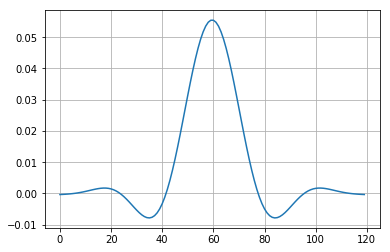

In [11]:
dt = (ds.time[1]-ds.time[0])
h = signal.firwin(24*5, cutoff=[1./(1.5*86400)], pass_zero=True, nyq=1./2/dt, scale=True)

ax = plt.subplot(111)
ax.plot(h)
ax.grid()

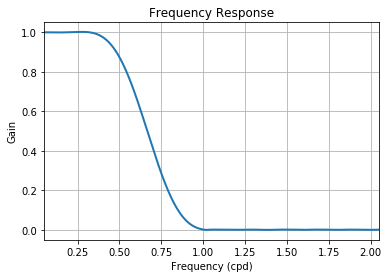

In [12]:
w, hh = signal.freqz(h, worN=8000)
plt.plot((w/np.pi)/2/dt.values*3600*24, abs(hh), linewidth=2)
plt.xlabel('Frequency (cpd)')
plt.ylabel('Gain')
plt.title('Frequency Response')
plt.ylim(-0.05, 1.05)
plt.xlim(0.05, 2.05)
plt.grid(True)

---

## filtering @ 1 location

In [13]:
#lds = ds.isel(i=slice(5), j=slice(4000,4100))
lds = ds.isel(i=slice(5), j=slice(0,100))

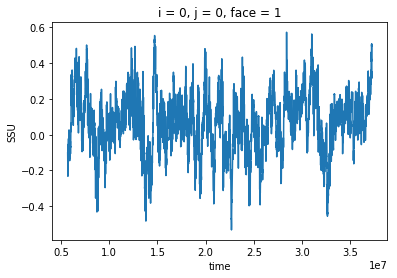

In [14]:
lds[v].isel(i=0,j=0).plot()

In [61]:
def conv(x, t, omega):
    ''' omega is in cpd
    '''
    if omega>0:
        return im.convolve1d(x * np.cos(2.*np.pi*omega*t), h, axis=2, mode='constant') \
                + 1j * im.convolve1d(x * np.sin(2.*np.pi*omega*t), h, axis=2, mode='constant')
    else:
        lx = x
        return im.convolve1d(lx, h, axis=2, mode='constant')

def filt(v, omega=0):
    return xr.apply_ufunc(conv, v, v.time_days, omega, 
                    dask='parallelized', output_dtypes=[np.complex64],
                    input_core_dims=[['time'],['time'],[]],
                    output_core_dims=[['time']],
                    output_sizes={'time': len(v.time)})
    

In [62]:
v_low = filt(lds[v])
v_2 = filt(lds[v], omega=2.)
print(v_low)

<xarray.DataArray (i: 5, j: 100, time: 8760)>
dask.array<shape=(5, 100, 8760), dtype=complex64, chunksize=(1, 100, 8760)>
Coordinates:
  * i          (i) int64 0 1 2 3 4
  * j          (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
    face       int64 1
  * time       (time) float64 5.702e+06 5.706e+06 5.71e+06 5.713e+06 ...
    dtime      (time) datetime64[ns] dask.array<shape=(8760,), chunksize=(8760,)>
    time_days  (time) float64 dask.array<shape=(8760,), chunksize=(8760,)>


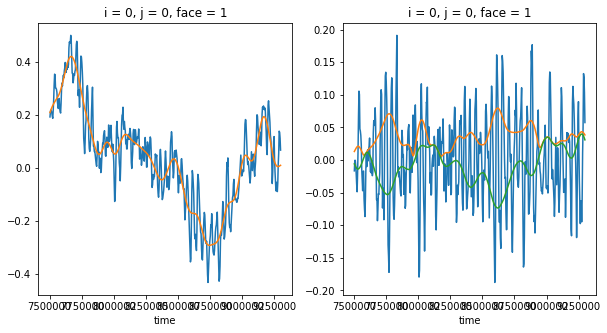

In [65]:
it = slice(500,1000)

fig = plt.figure(figsize=(10,5))
#
ax = plt.subplot(121)
lds[v].isel(i=0,j=0,time=it).plot(ax=ax)
v_low.isel(i=0,j=0,time=it).plot(ax=ax)
#
ax = plt.subplot(122)
(lds[v] - v_low).isel(i=0,j=0,time=it).plot(ax=ax)
np.abs(v_2).isel(i=0,j=0,time=it).plot(ax=ax)
np.real(v_2).isel(i=0,j=0,time=it).plot(ax=ax)

---

## filtering over the entire tile

In [27]:
v_f =filt(ds[v])

In [28]:
print(v_f)

<xarray.DataArray 'SSU' (i: 4320, j: 4320, time: 8760)>
dask.array<shape=(4320, 4320, 8760), dtype=float64, chunksize=(1, 4320, 8760)>
Coordinates:
  * i          (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * j          (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
    face       int64 1
  * time       (time) float64 5.702e+06 5.706e+06 5.71e+06 5.713e+06 ...
    dtime      (time) datetime64[ns] dask.array<shape=(8760,), chunksize=(8760,)>
    time_days  (time) float64 dask.array<shape=(8760,), chunksize=(8760,)>


In [ ]:
it=100

lv =  ds[v].isel(time=it)
lv = lv.persist()

lvf = v_f.isel(time=it)
lvf = lvf.persist()

In [ ]:
plt.figure(figsize=(10,10))

#
ax=plt.subplot(221)
lv.plot(ax=ax, x='i', y='j')
ax.set_title(v)

#
ax=plt.subplot(222)
lvf.plot(ax=ax, x='i', y='j')
ax.set_title('filtered '+v)

#
ax=plt.subplot(223)
(lv-lvf).plot(ax=ax, x='i', y='j')
ax.set_title('anomaly '+v)


In [ ]:
# store in netcdf files
to do 

Nt = 24*10 # time windows to consider
fsize_bound = 1e20
it = np.arange(lds.time.size/Nt-1).astype(int)*Nt
#it = np.arange(10).astype(int)*Nt # tmp
assert it[-1]+Nt<lds.time.size
#
#for face in range(ds['face'].size):
for i, t in enumerate(it):
    #
    file_out = out_dir+'/%s_filtered_f%02d_t%02d.nc'%(v, face, i)
    if not os.path.isfile(file_out) or os.path.getsize(file_out) < fsize_bound:            
        dv = lds_f.isel(time=slice(t,t+Nt))
        #
        dv = dv.chunk({'time': dv['time'].size, 'i': 432, 'j': 432})
        chunksizes = [432, 432, dv['time'].size]
        #
        dv = dv.load() # this may be required in order to prevent pickle related errors
        #
        while True:
            try:
                %time dv.to_netcdf(file_out, mode='w', unlimited_dims=['time'], \
                                   encoding={'Eta': {'chunksizes': chunksizes}})
            except:
                print('Failure')
            break
            #if os.path.isfile(file_out) and os.path.getsize(file_out)>fsize_bound:
            #    #
            #    print('face=%d / i=%d'%(face,i))
            #    break
    else:
        print('face=%d / i=%d - allready processed'%(face,i))

---

In [27]:
# add workers
w = cluster.start_workers(10)

In [ ]:
# kill scheduler, workers
cluster.scheduler.close()
#cluster.stop_workers(cluster.jobs)

In [ ]:
# restart workers
client.restart()

In [31]:
client

Client Scheduler: tcp://10.148.1.2:50233 Dashboard: http://10.148.1.2:8787/status,Cluster Workers: 60 Cores: 240 Memory: 3000.00 GB
